## Variational Inference with JAX

Consider the filtering distributions for a dynamical system at times $j = 0,\dots,J$:
$$\pi_j = \mathbb{P}(v_j | y_1^\dagger, \dots, y_j^\dagger)$$

Filtering evolves according to the recursion:\
&nbsp; **Prediction step**: $\widehat\pi_{j+1} = \mathsf{P}\pi_j$, where $\widehat\pi_{j+1} = \mathbb{P}(v_{j+1}|y_1^\dagger, \dots, y_j^\dagger)$\
&nbsp; **Analysis step**: $\pi_{j+1} = \mathsf{A}(\widehat\pi_{j+1};y_{j+1}^\dagger)$

Approximate $\pi_{j+1} \approx q_{j+1}$ at each step of filtering by minmizing the KL divergence objective:
$$\arg\min_q D_{KL}(q || \pi_{j+1}) = \arg\min_q D_{KL}(q||\widehat\pi_{j+1}) - \mathbb{E}_{u \sim q}[\log \mathsf{I}(y_{j+1}^\dagger;u)]$$

We will define $q_j(\theta)$ recursively using a procedure, which depends on parameters $\theta = K$. Then, the objective will be:
$$\min_\theta \frac{1}{J}\sum_{j=0}^J L_{j}(q_j(\theta))$$

In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, eigh
from tqdm.auto import tqdm
from jax.tree_util import Partial
from functools import partial

/Users/ricardobaptista/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define parameters and true data

In [2]:
# System dimensions
n = 40              # System dimension
p = 2               # Observation dimension
J0 = 0              # burn in period
N = 10              # Monte Carlo samples for cost function sampling
num_steps = 1000    # Number of time steps
F = 8.0
dt = 0.05

# Model parameters
m0 = jnp.ones((n,))
C0 = jnp.eye(n) * 1.0    # Initial state covariance matrix (P)
Q = jnp.eye(n)* 0.1      # Process noise covariance matrix (Sigma in Julia code). We use diagonal for nonlinear case
H = jnp.eye(n)           # Observation noise matrix 
R = jnp.eye(H.shape[0])  # R is dependent on number of observed states (also written as Gamma)

observation_interval = 1

## Simulate true states and observations

We consider the Lorenz-96 coupled nonlinear ODE:
$$\frac{dv_i}{dt} = (v_{i+1} - v_{i-2})v_{i-1} - v_i + F, \qquad i = 1,\dots,n$$
starting from initial condition $v \sim \mathcal{N}(m_0,C_0)$ with $m_0 = 0$ and $C_0 = I_n$.

We discretize the model: $v(t) = (v_1,\dots,v_n)$ and define the discretized system:
$$v(t+\Delta t) = \Psi(v(t)) + \xi, \qquad \xi \sim \mathcal{N}(0,\Sigma)$$

We observe each state: $y_i = v_i + \epsilon_i, \qquad \epsilon_i \sim \mathcal{N}(0,\Gamma)$

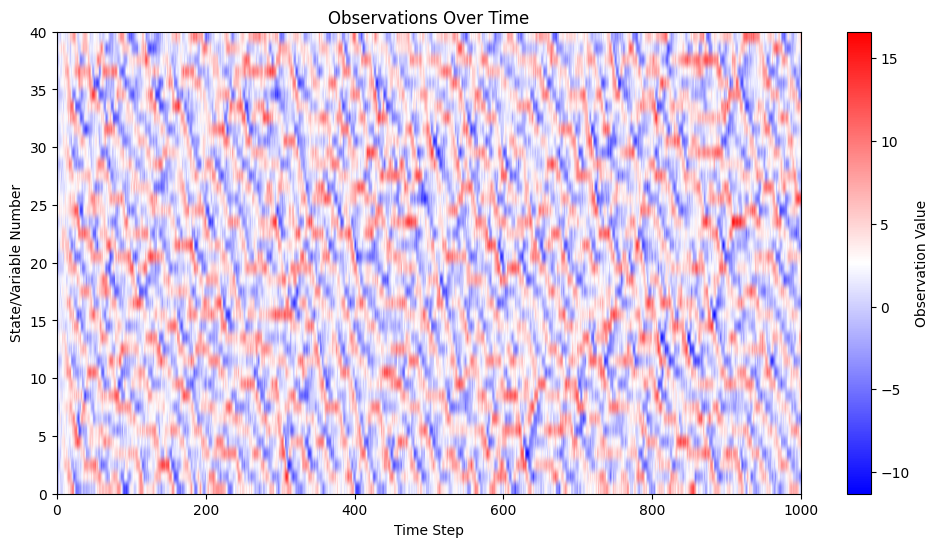

In [3]:
from jax import lax

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

@jit
def rk4_step(x, F, dt):
    f = lambda y: (jnp.roll(y, 1) - jnp.roll(y, -2)) * jnp.roll(y, -1) - y + F
    k1 = dt * f(x)
    k2 = dt * f(x + k1/2)
    k3 = dt * f(x + k2/2)
    k4 = dt * f(x + k3)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

class Lorenz96:
    def __init__(self, dt=0.01, F=8.0):
        self.dt = dt
        self.F = F

    def step(self, x):
        return rk4_step(x, self.F, self.dt)

@jit
def step_function(carry, input):
    key, x, observation_interval, H, Q, R, model_step, counter = carry
    n = len(x)
    key, subkey = random.split(key)
    x_j = model_step(x)
    # Add process noise Q only at observation times using a conditional operation
    def update_observation():
        x_noise = x_j + random.multivariate_normal(key, jnp.zeros(n), Q)
        obs_state = jnp.dot(H, x_noise)
        # Adjust noise dimension to the number of observed states
        obs_noise = random.multivariate_normal(subkey, jnp.zeros(H.shape[0]), R) 
        return x_noise, obs_state + obs_noise
    def no_update():
        # Return a vector of NaNs matching the number of observed states
        return x_j, jnp.nan * jnp.ones(H.shape[0])
    # Conditional update based on the observation interval
    x_j, obs = lax.cond(counter % observation_interval == 0,
                        update_observation,
                        no_update)
    counter += 1
    carry = (key, x_j, observation_interval, H, Q, R, model_step, counter)
    output = (x_j, obs)
    return carry, output

@partial(jit, static_argnums=(1, 2, 7))
def generate_true_states(key, num_steps, n, x0, H, Q, R, model_step, observation_interval):
    initial_carry = (key, x0, observation_interval, H, Q, R, model_step, 1)
    _, (xs, observations) = lax.scan(step_function, initial_carry, None, length=num_steps-1)
    key, subkey = random.split(key)
    initial_observation = H @ x0 + random.multivariate_normal(subkey, jnp.zeros(H.shape[0]), R)
    xs = jnp.vstack([x0[jnp.newaxis, :], xs])
    observations = jnp.vstack([initial_observation[jnp.newaxis, :], observations])
    return observations, xs

# generate initial condition
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state

# define model step function
l96_model = Lorenz96(dt = dt, F = F)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)

# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)
y = observations

def visualize_observations(observations):
    observation_values = observations.T  # Transpose for plotting
    cmap = LinearSegmentedColormap.from_list('CustomColormap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])
    plt.figure(figsize=(12, 6))
    plt.imshow(observation_values, cmap=cmap, aspect='auto', extent=[0, observations.shape[0], 0, observations.shape[1]])
    plt.colorbar(label='Observation Value')
    plt.xlabel('Time Step')
    plt.ylabel('State/Variable Number')
    plt.title('Observations Over Time')
    plt.show()

visualize_observations(observations)

## Variational Inference:

Approximate filtering distribution $\pi_j(v_j) \approx q_j(v_j;\theta) = \mathcal{N}(v_j;m_j(K),C_j(K))$:

Implement predict and analysis step using parameterized 3DVar to update $q_j$ distribution:\
&nbsp; **Prediction step**: 
$$\widehat m_{j+1} = \Psi(m_j), \qquad \widehat C_{j+1} = J_j C_j J_j^T + \Sigma $$

&nbsp; **Analysis step**: 
$$ m_{j+1} = \widehat{m}_{j+1} + K(y_{j+1}^\dagger - Hm_{j+1}) $$
$$ C_{j+1} = (I - KH)\widehat{C}_{j+1} (I - KH)^T + K\Gamma K^T $$


## Define objective function

Consider Gaussian distributions $q_j(\theta)$ defined recursively given $K = \theta$:\\

**Prediction step**:

  \begin{align}
  \widehat{m}_{j+1} &= \Psi(m_j) \\
  \widehat{C}_{j+1} &= J_j C_j J_j^T + \Sigma, \qquad J_j = \text{ Jacobian of } \Psi
  \end{align}

**Analysis step**:

  \begin{align*}
  m_{j+1} &= \widehat{m}_{j+1} + K(y_{j+1}^\dagger - Hm_{j+1}) \\
  C_{j+1} &= (I - KH)\widehat{C}_{j+1} (I - KH)^T + K\Gamma K^T 
  \end{align*}

Define: $\widehat\pi_{j+1} = \mathcal{N}(\widehat{m}_{j+1}, \widehat{C}_{j+1})$ and $q_{j+1}(K) = \mathcal{N}(m_{j+1}(K),C_{j+1}(K))$

**Goal**: Learn $K$ that yields close filters for all time $j$ by minimizing the variational inference objective for each step of filtering:
 $$L(K) := \frac{1}{J} \sum_{j=1}^J D_{KL}(q_{j+1}(K)||\widehat\pi_{j+1}) - \mathbb{E}_{u \sim q_{j+1}(K)}[\log \mathsf{I}(u;y_{j+1})]$$


In [4]:
from jax.lax import scan

jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)

@jit
def KL_gaussian(n, m1, C1, m2, C2):
    """Computes the Kullback-Leibler divergence between two Gaussian distributions """
    C2_inv = inv(C2)
    # replace log(det(C2) / det(C1)), works better with limited precision because the determinant is practically 0
    log_det_ratio = (jnp.log(eigh(C2)[0]).sum() - jnp.log(eigh(C1)[0]).sum()).real 
    return 0.5 * (log_det_ratio - n + jnp.trace(C2_inv @ C1) + ((m2 - m1).T @ C2_inv @ (m2 - m1)))

@jit
def log_likelihood(v, y, H, R, J, J0):
    """ Computes the log-likelihood of observations given state estimates as a sum. Compares this to R, observation noise """
    def log_likelihood_j(_, v_y):
        v_j, y_j = v_y
        error = y_j - H @ v_j
        ll = error.T @ inv(R) @ error
        return _, ll
    _, lls = scan(log_likelihood_j, None, (v, y))
    sum_ll = jnp.nansum(lls)
    return -0.5 * sum_ll - 0.5 * (J - J0) * jnp.log(2 * jnp.pi) - 0.5 * (J - sum(jnp.isnan(lls)) - J0) * jnp.linalg.slogdet(R)[1]

@partial(jit, static_argnums=())
def KL_sum(m_preds, C_preds, m_updates, C_updates, n, state_transition_function, Q, key):
    """ Computes the sum of KL divergences between the predicted and updated state distributions. """
    def KL_j(_, m_C_y):
        m_pred, C_pred, m_update, C_update = m_C_y
        return _, KL_gaussian(n, m_update, C_update, m_pred, C_pred)
    _, mean_kls = scan(KL_j, None, (m_preds, C_preds, m_updates, C_updates))
    kl_sum = jnp.sum(mean_kls)
    return kl_sum

@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, H, Q, R, y, key, num_steps, J0):
    m_preds, C_preds, m_updates, C_updates = apply_filtering_fixed_nonlinear(m0, C0, y, K, n, l96_step, jac_func, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(m_preds, C_preds, m_updates, C_updates, n, l96_step, Q, key)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, m_updates, C_updates), y, H, R, num_steps, J0) 
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    print(cost)
    return cost

@partial(jit, static_argnums=(4))
def apply_filtering_fixed_nonlinear(m0, C0, y, K, n, state_transition_function, jacobian_function, H, Q, R):
    """ Applies the filtering process to estimate the system state over time for a non-linear model.
    """
    partial_filter_step = lambda m_C_prev, y_curr: filter_step_nonlinear(m_C_prev, y_curr, K, n, state_transition_function, jacobian_function, H, Q, R)
    _, m_C = lax.scan(partial_filter_step, (m0, C0, m0, C0), y)
    m_preds, C_preds, m_updates, C_updates = m_C
    return m_preds, C_preds, m_updates, C_updates

@partial(jit, static_argnums=(3))
def filter_step_nonlinear(m_C_prev, y_curr, K, n, state_transition_function, jacobian_function, H, Q, R):
    """
    Apply a single forecast and Kalman filter step for a non-linear model.
    Returns: Tuple of updated state estimate (mean) and covariance for both the return and next step
    """
    _, _, m_prev, C_prev = m_C_prev
    m_pred = state_transition_function(m_prev)
    F_jac = jacobian_function(m_prev)
    m_update = (jnp.eye(n) - K @ H) @ m_pred + K @ y_curr
    C_pred = F_jac @ C_prev @ F_jac.T + Q
    C_update = (jnp.eye(n) - K @ H) @ C_pred @ (jnp.eye(n) - K @ H).T + K @ R @ K.T #no discard yet
    return (m_pred, C_pred, m_update, C_update), (m_pred, C_pred, m_update, C_update)

@partial(jit, static_argnums=(3))
def var_cost_single_step(K, m0, C0, n, Q, H, R, y_curr, key, J, J0):
    (m_update, C_update), _  =  filter_step_nonlinear((m0,C0), y_curr, K, n, l96_step, jac_func, H, Q, R)
    log_likelihood_val = log_likelihood(m_update[jnp.newaxis, :], y_curr[jnp.newaxis, :], H, R, J=1, J0=J0)
    # Calculate the KL divergence between the predicted and updated state distributions
    m_pred = state_transition_function(m0)
    M = jac_func(m0)
    C_pred = M @ C0 @ M.T + Q
    kl_divergence = KL_gaussian(n, m_update, C_update, m_pred, C_pred)
    # Combine the KL divergence and the negative log-likelihood to form the cost
    cost = kl_divergence - log_likelihood_val
    return cost


## Run optimization

In [5]:
@jit
def kalman_step(state, observation, params):
    m_prev, C_prev = state
    state_transition_function, jacobian_function, H, Q, R = params
    m_pred = state_transition_function(m_prev)
    F_jac = jacobian_function(m_prev)
    C_pred = F_jac @ C_prev @ F_jac.T + Q
    S = H @ C_pred @ H.T + R
    K_curr = C_pred @ H.T @ jnp.linalg.inv(S)
    m_update = m_pred + K_curr @ (observation - H @ m_pred)
    C_update = (jnp.eye(H.shape[1]) - K_curr @ H) @ C_pred
    return (m_update, C_update), (m_update, C_update, K_curr)

@jit
def kalman_filter_process(state_transition_function, jacobian_function, m0, C0, observations, H, Q, R):
    params = (state_transition_function, jacobian_function, H, Q, R)
    initial_state = (m0, C0)
    _, (m, C, K) = lax.scan(lambda state, obs: kalman_step(state, obs, params),
                            initial_state, observations)
    return m, C, K

base_m, base_C, base_K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)
K_steady = jnp.mean(base_K[-50:, :, :], axis=0)    

In [6]:
var_cost_grad = grad(var_cost, argnums=0)

# Initial guess for K and optimization parameters
K_opt = jnp.eye(n) * 0.4

# step size and number of iterations
alpha = 1e-5
n_iters = 100

prediction_errors = [] 
true_div = []
last_200_errors = []


for i in tqdm(range(n_iters)):
    key, _ = random.split(key)
    # Update the gradient and Kalman gain
    grad_K = var_cost_grad(K_opt, m0, C0, n, H, Q, R, y, key, num_steps, J0)
    K_opt -= alpha * grad_K
    
    # Apply filtering with the newly optimized K to generate state predictions
    _, _, predicted_states, covariances = apply_filtering_fixed_nonlinear(m0, C0, y, K_opt, n, l96_step, jac_func, H, Q, R)
    
    prediction_error = jnp.mean(jnp.mean((predicted_states - true_states)**2, axis=1))
    prediction_errors.append(prediction_error)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, predicted_states[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t 
    true_div.append(total_kl_divergence / num_steps)



  0%|          | 0/100 [00:00<?, ?it/s]

JitTracer<float32[]>


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


## Post-process results

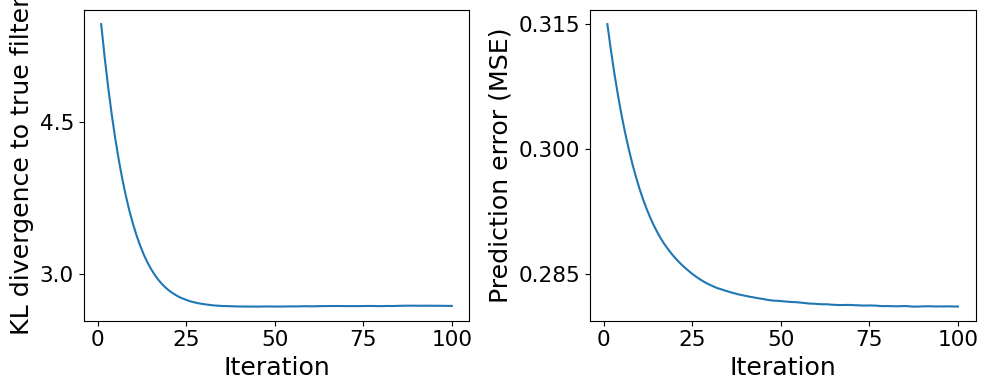

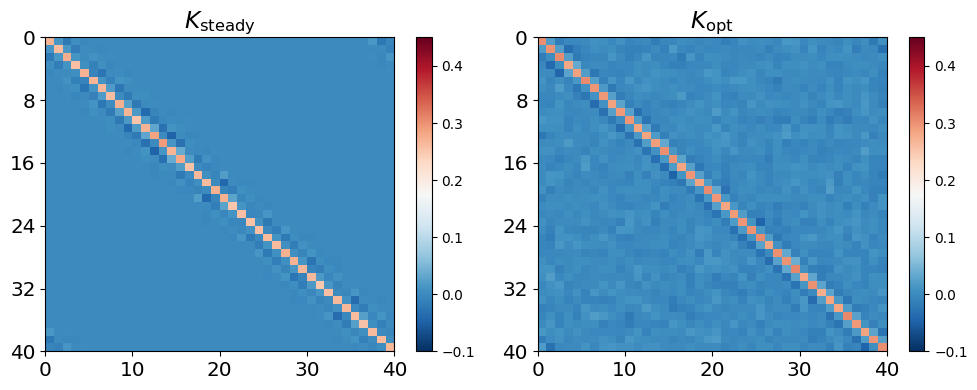

In [12]:
import os
#from jax_vi import plot_optimization_results, plot_k_matrices

def plot_optimization_results(prediction_errors, true_div, n_iters, scaling=1.3, max_n_locator=5):
    """
    norms (list): List of norm values representing norm from reference K.
    prediction_errors (list): List of prediction error values (MSE).
    true_div (list): List of KL divergence values (from Kalman Filter solution).
    n_iters (int): Number of iterations to plot.
    file_path (str): Path to save the plot as a PDF file.
    scaling (float): Scaling factor for font and label sizes.
    max_n_locator (int): Maximum number of labels on the y-axis.
    """
    fig, (ax1, ax3) = plt.subplots(figsize=(10, 4), ncols=2)
    
    # K norms and KL Divergence
    color = 'tab:red'
    ax1.set_xlabel('Iteration', fontsize=14*scaling)
    ax1.tick_params(axis='y', labelsize=12*scaling)
    ax1.tick_params(axis='x', labelsize=12*scaling)
    ax1.yaxis.set_major_locator(plt.MaxNLocator(max_n_locator))
    ax1.set_ylabel('KL divergence to true filter', fontsize=14*scaling)
    ax1.plot(range(1, n_iters+1), true_div[:n_iters], label='KL divergence to true filter')
    ax1.yaxis.set_major_locator(plt.MaxNLocator(max_n_locator))

    # MSE from True States
    ax3.plot(range(1, n_iters+1), prediction_errors[:n_iters])
    ax3.set_xlabel("Iteration", fontsize=14*scaling)
    ax3.set_ylabel("Prediction error (MSE)", fontsize=14*scaling)
    ax3.tick_params(axis='x', labelsize=12*scaling)
    ax3.tick_params(axis='y', labelsize=12*scaling)
    ax3.yaxis.set_major_locator(plt.MaxNLocator(max_n_locator))

    plt.tight_layout()
    plt.show()
plot_optimization_results(prediction_errors, true_div, n_iters, scaling=1.3, max_n_locator=3)

def plot_k_matrices(K_steady, K_opt, scaling=1.2, max_n_locator=5):
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)
    
    c1 = ax1.pcolormesh(K_steady, vmin=-0.1, vmax=0.45, cmap='RdBu_r')
    ax1.set_title('$K_\\mathrm{steady}$', fontsize=14*scaling)
    ax1.invert_yaxis()
    ax1.tick_params(axis='x', labelsize=12*scaling)
    ax1.tick_params(axis='y', labelsize=12*scaling)
    ax1.yaxis.set_major_locator(plt.MaxNLocator(max_n_locator))
    fig.colorbar(c1,orientation='vertical')

    c2 = ax2.pcolormesh(K_opt, vmin=-0.1, vmax=0.45, cmap='RdBu_r')
    ax2.set_title('$K_\\mathrm{opt}$', fontsize=14*scaling)
    ax2.invert_yaxis()
    ax2.tick_params(axis='x', labelsize=12*scaling)
    ax2.tick_params(axis='y', labelsize=12*scaling)
    ax2.yaxis.set_major_locator(plt.MaxNLocator(max_n_locator))

    #cb_ax = fig.add_axes([.93, .124, .02, .754])  # add and align colorbar
    fig.colorbar(c2,orientation='vertical')

    plt.tight_layout()
    plt.show()
plot_k_matrices(K_steady, K_opt, scaling=1.2, max_n_locator=5)


## Test learned gain on new data

In [13]:
# using a new random key and a new initialization to test out of distribution performance for learned gain
key = random.PRNGKey(42)
initial_state = random.normal(key, (n,))  # Initial state
test_observations, test_true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)
y = test_observations
base_m, base_C, base_K = kalman_filter_process(l96_step, jac_func, m0, C0, test_observations, H, Q, R)

_, _, test_states, test_covariances = apply_filtering_fixed_nonlinear(m0, C0, y, K_opt, n, l96_step, jac_func, H, Q, R)
prediction_error = jnp.mean(jnp.mean((test_states - test_true_states)**2, axis=1))
print(f"Train Error for fixed gain: {prediction_errors[-1]:.4f}")
print(f"Test Error for fixed gain: {prediction_error:.4f}")

Train Error for fixed gain: 0.2811
Test Error for fixed gain: 0.3069


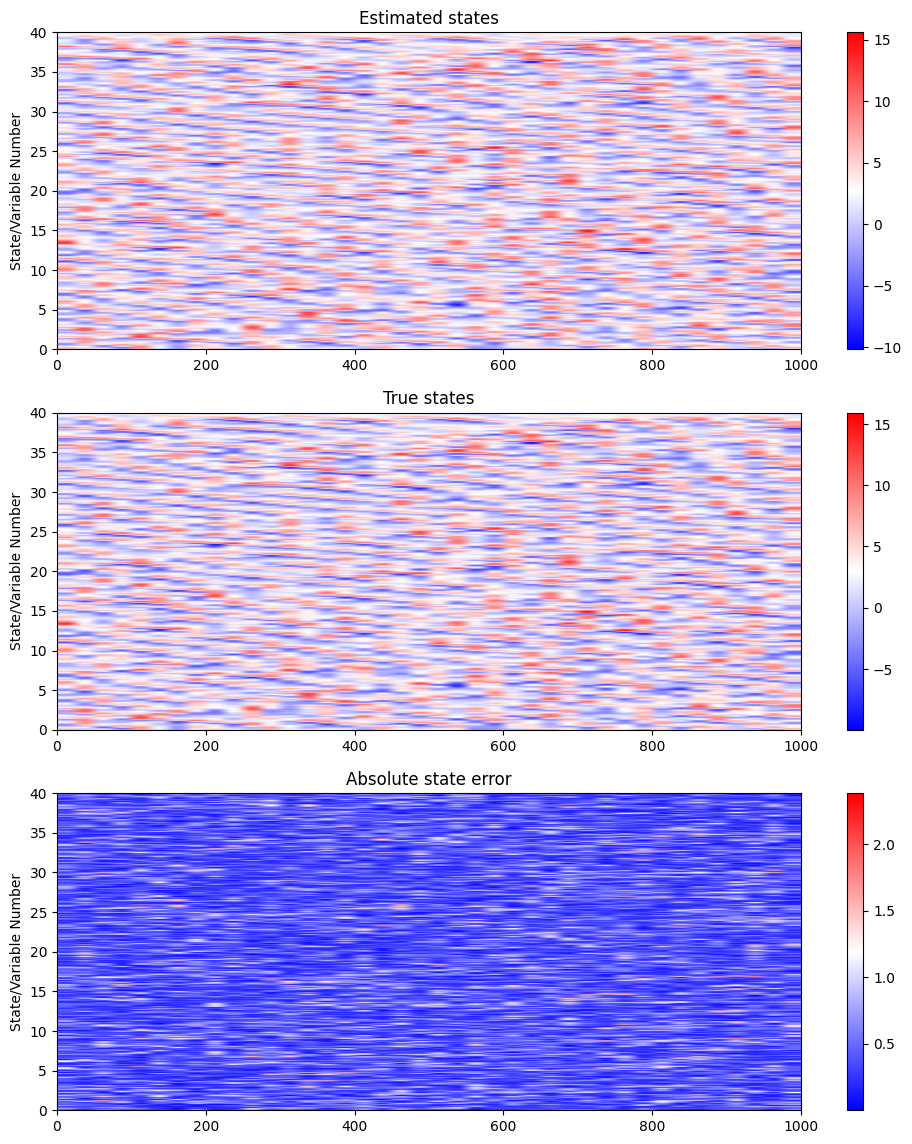

In [14]:
cmap = LinearSegmentedColormap.from_list('CustomColormap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])

plt.figure(figsize=(12,14))
plt.subplot(3,1,1)
plt.imshow(test_states, cmap=cmap, aspect='auto', extent=[0, observations.shape[0], 0, observations.shape[1]])
plt.colorbar()
#plt.xlabel('Time Step')
plt.ylabel('State/Variable Number')
plt.title('Estimated states')
plt.subplot(3,1,2)
plt.imshow(test_true_states, cmap=cmap, aspect='auto', extent=[0, observations.shape[0], 0, observations.shape[1]])
plt.colorbar()
#plt.xlabel('Time Step')
plt.ylabel('State/Variable Number')
plt.title('True states')
plt.subplot(3,1,3)
plt.imshow(jnp.abs(test_true_states - test_states), cmap=cmap, aspect='auto', extent=[0, observations.shape[0], 0, observations.shape[1]])
plt.colorbar()
#plt.xlabel('Time Step')
plt.ylabel('State/Variable Number')
plt.title('Absolute state error')
plt.show()
